# 1141ML Final - DSM 1D

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cpu")

sigma_dsm=1.25
batch_size=2048


In [ ]:
def sample_noisy_x(batch_size, x_dim=1, sigma=0.5):
    mu1 = np.array([-2] + [0]*(x_dim-1), dtype=np.float32)
    mu2 = np.array([ 2] + [0]*(x_dim-1), dtype=np.float32)

    w = np.random.rand(batch_size) < 0.5
    x = np.zeros((batch_size, x_dim), dtype=np.float32)

    x[w]  = mu1 + np.random.randn(w.sum(),  x_dim).astype(np.float32)
    x[~w] = mu2 + np.random.randn((~w).sum(), x_dim).astype(np.float32)

    eps = np.random.randn(batch_size, x_dim).astype(np.float32)
    x_tilde = x + sigma * eps

    return x_tilde, eps


In [ ]:
class ScoreNet(nn.Module):
    def __init__(self, x_dim, hidden, num_layers):
        super().__init__()

        layers = [nn.Linear(x_dim, hidden), nn.SiLU()]
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden, hidden))
            layers.append(nn.SiLU())
        layers.append(nn.Linear(hidden, x_dim)) 

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

model=ScoreNet(x_dim =1, hidden=64, num_layers=3).to(device)


def dsm_loss_step(x_dim):
    x_tilde_np, eps_np = sample_noisy_x(batch_size, x_dim, sigma_dsm)

    x_tilde = torch.from_numpy(x_tilde_np).to(device)
    eps     = torch.from_numpy(eps_np).to(device)

    s_hat = model(x_tilde)

    target = -eps / sigma_dsm   
    loss = ((s_hat - target)**2).mean()
    return loss



In [ ]:
#### Training Loop
num_steps=5000
lr=5e-3

optimizer=optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,       
    patience=200,     
    verbose=True
)
loss_history = []

for step in range(1, num_steps+1):
    model.train()

    loss = dsm_loss_step(1)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

 
    scheduler.step(loss)

    loss_history.append(loss.item())

    if step % 200 == 0:
        print(f"step {step:4d} | loss = {loss.item():.6f} | lr = {lr:.6f}")


c:\Users\user\.conda\envs\ml_env\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


step  200 | loss = 0.445101 | lr = 0.005000
step  400 | loss = 0.440692 | lr = 0.005000
step  600 | loss = 0.450874 | lr = 0.005000
step  800 | loss = 0.445625 | lr = 0.005000
step 1000 | loss = 0.444133 | lr = 0.005000
step 1200 | loss = 0.426766 | lr = 0.005000
step 1400 | loss = 0.449172 | lr = 0.005000
step 1600 | loss = 0.425792 | lr = 0.005000
step 1800 | loss = 0.436817 | lr = 0.005000
step 2000 | loss = 0.403777 | lr = 0.005000
step 2200 | loss = 0.436520 | lr = 0.005000
step 2400 | loss = 0.460981 | lr = 0.005000
step 2600 | loss = 0.431078 | lr = 0.005000
step 2800 | loss = 0.455819 | lr = 0.005000
step 3000 | loss = 0.423604 | lr = 0.005000
step 3200 | loss = 0.422912 | lr = 0.005000
step 3400 | loss = 0.425996 | lr = 0.005000
step 3600 | loss = 0.439106 | lr = 0.005000
step 3800 | loss = 0.428314 | lr = 0.005000
step 4000 | loss = 0.422189 | lr = 0.005000
step 4200 | loss = 0.445860 | lr = 0.005000
step 4400 | loss = 0.447891 | lr = 0.005000
step 4600 | loss = 0.444640 | lr

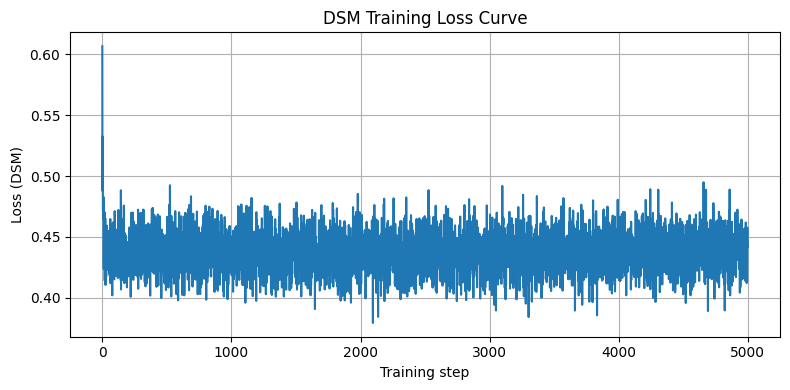

In [5]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_list):
    """
    loss_list: Python list or Tensor containing loss values for each step
    """
    plt.figure(figsize=(8,4))
    plt.plot(loss_list, linewidth=1.5)
    plt.xlabel("Training step")
    plt.ylabel("Loss (DSM)")
    plt.title("DSM Training Loss Curve")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_loss_curve(loss_history)

In [6]:
print(sigma_dsm)

1.25


## Sampling

In [7]:
def langevin_sampling(model, steps=6000, eta=0.002, x_dim=1):
    model.eval()
    x = torch.randn(5000, x_dim).to(device)

    sqrt_term = torch.sqrt(torch.tensor(2*eta, device=device))

    for k in range(steps):
        with torch.no_grad():
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + sqrt_term * noise

    return x.detach().cpu().numpy()


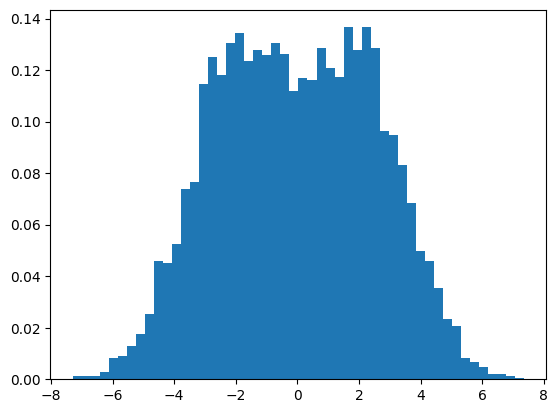

In [8]:
samples = langevin_sampling(model, x_dim=1)
plt.hist(samples, bins=50, density=True)
plt.show()


In [ ]:

from matplotlib.gridspec import GridSpec

def langevin_trajectories(model, steps=2000, eta=0.02, x_dim=1,
                          N_total=5000, K_traj=20):
    """
    N_total: 一共多少條軌跡用來做分布
    K_traj : 中間圖要畫出來的軌跡條數
    """
    model.eval()

    
    x = torch.randn(N_total, x_dim, device=device)
    x_init_all = x.detach().cpu().numpy().copy()

    
    x_traj = x[:K_traj].clone()
    traj_hist = [x_traj.detach().cpu().numpy().copy()]   # shape (K_traj, x_dim)

    for k in range(steps):
        with torch.no_grad():
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + torch.sqrt(torch.tensor(2*eta, device=device)) * noise

            x_traj = x[:K_traj]
            traj_hist.append(x_traj.detach().cpu().numpy().copy())

    x_final_all = x.detach().cpu().numpy().copy()
    traj_hist = np.stack(traj_hist, axis=0)   # shape: (steps+1, K_traj, x_dim)

    return x_init_all, x_final_all, traj_hist

steps = 2000
eta = 0.02
x_dim = 1

x_init_all, x_final_all, traj_hist = langevin_trajectories(
    model, steps=steps, eta=eta, x_dim=x_dim,
    N_total=5000, K_traj=20
)


In [ ]:
def forward_backward_process(model, steps=2000, eta=0.02, x_dim=1,
                             N_total=5000, K_traj=20, sigma=0.5):

    model.eval()

    # ===== 0: sample real data x0 =====
    x0_np, _ = sample_noisy_x(N_total, x_dim, sigma=0) 
    x0 = torch.from_numpy(x0_np).to(device)

    # ===== T: forward noise xT = x0 + sigma * eps =====
    eps = torch.randn_like(x0)
    xT = x0 + sigma * eps
    xT_np = xT.detach().cpu().numpy().copy()

    # ===== T -> 0' : Langevin dynamics =====
    x = xT.clone()
    xT_traj = x[:K_traj].clone()
    traj_hist = [xT_traj.detach().cpu().numpy().copy()]

    for k in range(steps):
        with torch.no_grad():
            score = model(x)
            noise = torch.randn_like(x)
            x = x + eta * score + torch.sqrt(torch.tensor(2*eta, device=device)) * noise

            xT_traj = x[:K_traj]
            traj_hist.append(xT_traj.detach().cpu().numpy().copy())

    x0_prime_np = x.detach().cpu().numpy().copy()
    traj_hist = np.stack(traj_hist, axis=0)

    return x0_np, xT_np, x0_prime_np, traj_hist


C:\Users\user\AppData\Local\Temp\ipykernel_16920\2033812610.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


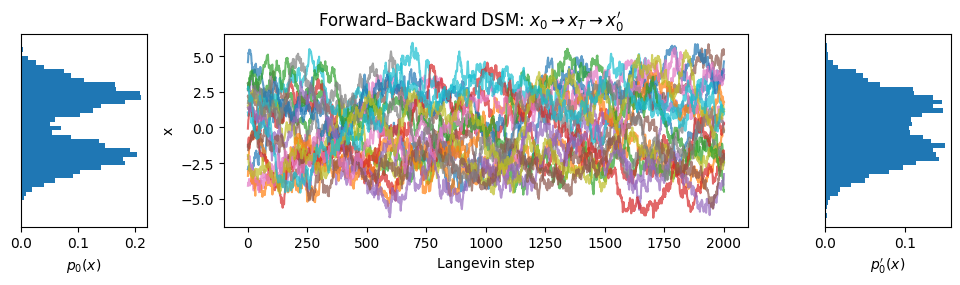

In [ ]:
x0_np, xT_np, x0p_np, traj_hist = forward_backward_process(
    model, steps=2000, eta=0.02, x_dim=1, N_total=5000
)

fig = plt.figure(figsize=(12, 2.5))
gs = GridSpec(1, 3, width_ratios=[1.2, 5, 1.2], wspace=0.3)

ax_left  = fig.add_subplot(gs[0, 0])
ax_mid   = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])

# Left
ax_left.hist(x0_np[:,0], bins=40, density=True, orientation='horizontal')
ax_left.set_xlabel(r"$p_0(x)$")
ax_left.set_yticks([])

# Mid
t_axis = np.arange(traj_hist.shape[0])
for i in range(traj_hist.shape[1]):
    ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.7)
ax_mid.set_xlabel("Langevin step")
ax_mid.set_ylabel("x")

# Right
ax_right.hist(x0p_np[:,0], bins=40, density=True, orientation='horizontal')
ax_right.set_xlabel(r"$p_0'(x)$")
ax_right.set_yticks([])

plt.suptitle(r"Forward–Backward DSM: $x_0 \rightarrow x_T \rightarrow x_0'$")
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_16920\3737446641.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


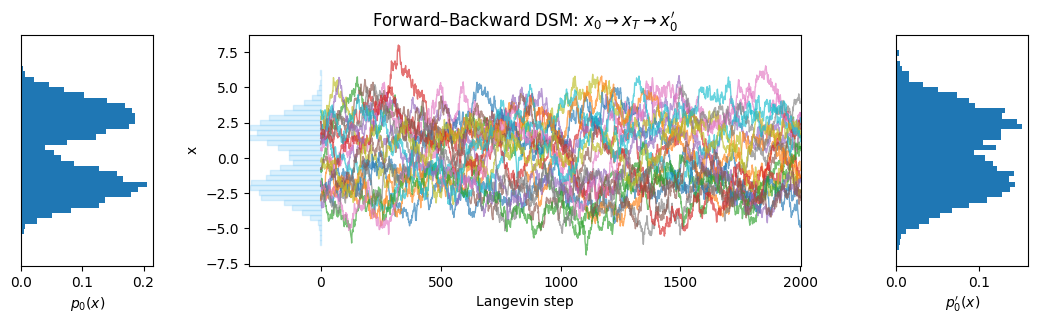

In [ ]:


x0_np, xT_np, x0p_np, traj_hist = forward_backward_process(
    model, steps=2000, eta=0.02, x_dim=1, N_total=5000
)


fig = plt.figure(figsize=(13, 3))
gs = GridSpec(1, 3, width_ratios=[1.2, 5, 1.2], wspace=0.35)

ax_left  = fig.add_subplot(gs[0, 0])
ax_mid   = fig.add_subplot(gs[0, 1])
ax_right = fig.add_subplot(gs[0, 2])


### Left
ax_left.hist(x0_np[:,0], bins=40, density=True, orientation='horizontal')
ax_left.set_xlabel(r"$p_0(x)$")
ax_left.set_yticks([])


### Mid
t_axis = np.arange(traj_hist.shape[0])
for i in range(traj_hist.shape[1]):
    ax_mid.plot(t_axis, traj_hist[:, i, 0], alpha=0.65, linewidth=1.0)
ymin, ymax = ax_mid.get_ylim()

hist_vals, hist_bins = np.histogram(xT_np[:,0], bins=35, density=True)
max_width = 0.15 * traj_hist.shape[0]
hist_vals = hist_vals / hist_vals.max() * max_width
for h, (y0, y1) in zip(hist_vals, zip(hist_bins[:-1], hist_bins[1:])):
    ax_mid.fill_betweenx([y0, y1], -h, 0,  # 左側區域：[-h, 0]
                         color='lightskyblue', alpha=0.30)

ax_mid.set_xlabel("Langevin step")
ax_mid.set_ylabel("x")
ax_mid.set_title(r"Forward–Backward DSM: $x_0 \rightarrow x_T \rightarrow x_0'$")

ax_mid.set_xlim(-max_width, traj_hist.shape[0])

### Right
ax_right.hist(x0p_np[:,0], bins=40, density=True, orientation='horizontal')
ax_right.set_xlabel(r"$p_0'(x)$")
ax_right.set_yticks([])

plt.tight_layout()
plt.show()
